In [1]:
import pyarrow.feather as feather
import pandas as pd
from datetime import datetime
import numpy as np
import math

import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt

In [29]:
df_baseload = feather.read_feather('baseload_profiles.feather')
df_baseload

,DATUM_TIJDSTIP,E1_OPWEK_CLUSTER_1,E1_OPWEK_CLUSTER_2,E1_OPWEK_CLUSTER_3,E1_OPWEK_CLUSTER_4,E1_OPWEK_CLUSTER_5,E1_VERBRUIK_CLUSTER_1,E1_VERBRUIK_CLUSTER_2,E1_VERBRUIK_CLUSTER_3,E1_VERBRUIK_CLUSTER_4,...,KVKSEGMENT_20,KVKSEGMENT_3,KVKSEGMENT_4,KVKSEGMENT_5,KVKSEGMENT_6,KVKSEGMENT_7,KVKSEGMENT_8,KVKSEGMENT_9,PV,WIND
0,2021-01-01 00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000031,0.000048,0.000013,0.000023,...,0.000021,0.000020,0.000011,0.000034,0.000024,0.000020,0.000016,0.000015,0.0,-0.148094
1,2021-01-01 00:15,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000030,0.000047,0.000013,0.000022,...,0.000022,0.000019,0.000011,0.000034,0.000023,0.000019,0.000016,0.000015,0.0,-0.124934
2,2021-01-01 00:30,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000028,0.000046,0.000013,0.000021,...,0.000021,0.000017,0.000011,0.000033,0.000022,0.000020,0.000016,0.000015,0.0,-0.141414
3,2021-01-01 00:45,-1.037100e-11,0.000000e+00,0.000000e+00,0.0,0.0,0.000026,0.000045,0.000013,0.000020,...,0.000021,0.000018,0.000012,0.000034,0.000023,0.000019,0.000016,0.000015,0.0,-0.142952
4,2021-01-01 01:00,0.000000e+00,-9.146000e-12,-4.390132e-09,0.0,0.0,0.000024,0.000044,0.000012,0.000019,...,0.000021,0.000021,0.000011,0.000034,0.000023,0.000018,0.000016,0.000015,0.0,-0.132363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2021-12-31 22:45,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000036,0.000050,0.000013,0.000026,...,0.000021,0.000019,0.000011,0.000024,0.000022,0.000020,0.000015,0.000017,0.0,-0.969697
35036,2021-12-31 23:00,-5.945400e-11,0.000000e+00,0.000000e+00,0.0,0.0,0.000034,0.000049,0.000013,0.000024,...,0.000015,0.000014,0.000009,0.000019,0.000017,0.000016,0.000013,0.000015,0.0,-0.823069
35037,2021-12-31 23:15,0.000000e+00,0.000000e+00,-6.975850e-10,0.0,0.0,0.000033,0.000047,0.000013,0.000024,...,0.000019,0.000016,0.000011,0.000021,0.000019,0.000019,0.000015,0.000017,0.0,-0.876833
35038,2021-12-31 23:30,0.000000e+00,0.000000e+00,-9.392800e-11,0.0,0.0,0.000032,0.000045,0.000013,0.000023,...,0.000019,0.000014,0.000010,0.000021,0.000021,0.000020,0.000014,0.000016,0.0,-0.932551


Notes about data:
- TA_B1_NAME: (sub) station

- TA_B2_NAME: Installatie

- TA_B3_NAME: veld

- DATUM_TIJD: iedere 5 minuten

In [30]:
df = feather.read_feather('ems_metingen_pqi.feather')
df['DATUM_TIJD'] = pd.to_datetime(df['DATUM_TIJD'])

In [32]:
df_excel = pd.read_excel("ems_metingen_in_uitgaand.xlsx")
remove_lst = [3,4,5]
df_excel = df_excel.drop(df_excel.columns[remove_lst], axis = 1)
merged = pd.merge(df, df_excel, on=['TA_B1_NAME', 'TA_B2_NAME', 'TA_B3_NAME'], how='left')
merged

,TA_B1_NAME,TA_B2_NAME,TA_B3_NAME,IN_UITGAAND
0,HrvH,20-1i,V106,Uit
1,Nk,10,2.02,Uit
2,HrvH,20-1i,V102,Uit
3,Grd,10,INSTAL,nvt
4,Dtn,10,INSTAL2,nvt
...,...,...,...,...
136,Grd,10,V25,Uit
137,Tex,10,V149,nvt
138,Ns,10-2,TR3,nvt
139,Tex,10,V150,nvt


In [34]:
merged = pd.merge(df, df_excel, on=['TA_B1_NAME', 'TA_B2_NAME', 'TA_B3_NAME'], how='left')
merged

,ROUTE_ID,ROUTE_NAAM,TA_B1_NAME,TA_B2_NAME,TA_B3_NAME,M_POINT_P,M_POINT_Q,M_POINT_I,M_TIMESTAMP,DATUM_TIJD,...,FLAG_I,FLAG_MEETFOUT,FLAG_SCHAKEL_EVENT,SCHEMA_MS_VELD_ID,UPDATE_DATUMTIJD,M_VALUE_P,M_VALUE_Q,M_VALUE_I,BEDRIJFSSPANNING,IN_UITGAAND
0,10347710.0,"HRVH 20-1V6, V2",HrvH,20-1i,V106,0B875,0B876,0B874,2021-05-14 18:50:00.000000000,2021-05-14 16:50:00,...,0.0,0.0,0.0,10183207.0,None,0.00,0.00,0.00,0.0210,Uit
1,2871560.0,NK 10-1V2.08,Nk,10,2.08,05814,05815,047E7,2021-10-04 18:55:00.000000000,2021-10-04 16:55:00,...,1.0,0.0,0.0,2616351.0,None,0.30,-0.11,18.14,0.0105,Uit
2,10347710.0,"HRVH 20-1V6, V2",HrvH,20-1i,V102,0B865,0B866,0B864,2021-01-13 10:00:00.000000000,2021-01-13 09:00:00,...,0.0,0.0,0.0,10183126.0,None,0.44,0.02,11.81,0.0210,Uit
3,10347790.0,GRD 10-1V17,Grd,10,V17,068A2,068AB,04E55,2021-10-03 12:20:00.000000000,2021-10-03 10:20:00,...,1.0,0.0,0.0,10266102.0,None,0.23,-0.08,13.53,0.0105,Uit
4,NaN,None,Dtn,10,INSTAL2,0221D,0221E,,2021-06-11 16:30:00.000000000,2021-06-11 14:30:00,...,0.0,0.0,0.0,NaN,None,-6.20,-5.69,NaN,0.0105,nvt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14233997,NaN,None,Tex,10,V134,006FB,006FC,00704,2022-01-01 00:15:00.000000000,2021-12-31 23:15:00,...,0.0,0.0,0.0,NaN,None,-4.06,1.17,231.81,0.0105,In
14233998,NaN,None,Tex,10,V134,006FB,006FC,00704,2022-01-01 00:15:00.000000000,2021-12-31 23:15:00,...,0.0,0.0,0.0,NaN,None,-4.06,1.17,231.81,0.0105,In
14233999,14818605.0,RS DVD 10-3V308,Dvd-RS,10-3i,V308,0D57C,0D57D,0D57B,2022-01-01 00:50:00.000000000,2021-12-31 23:50:00,...,0.0,0.0,0.0,14685309.0,None,0.15,0.01,8.15,0.0105,Uit
14234000,NaN,None,Hby,10,WPBier,01C51,01C52,,2022-01-01 00:35:00.000000000,2021-12-31 23:35:00,...,0.0,0.0,0.0,NaN,None,0.13,-0.28,NaN,0.0105,nvt


In [4]:
print(df.columns)
df.head()

Index(['ROUTE_ID', 'ROUTE_NAAM', 'TA_B1_NAME', 'TA_B2_NAME', 'TA_B3_NAME',
       'M_POINT_P', 'M_POINT_Q', 'M_POINT_I', 'M_TIMESTAMP', 'DATUM_TIJD',
       'FLAG_P', 'FLAG_Q', 'FLAG_I', 'FLAG_MEETFOUT', 'FLAG_SCHAKEL_EVENT',
       'SCHEMA_MS_VELD_ID', 'UPDATE_DATUMTIJD', 'M_VALUE_P', 'M_VALUE_Q',
       'M_VALUE_I', 'BEDRIJFSSPANNING'],
      dtype='object')


,ROUTE_ID,ROUTE_NAAM,TA_B1_NAME,TA_B2_NAME,TA_B3_NAME,M_POINT_P,M_POINT_Q,M_POINT_I,M_TIMESTAMP,DATUM_TIJD,...,FLAG_Q,FLAG_I,FLAG_MEETFOUT,FLAG_SCHAKEL_EVENT,SCHEMA_MS_VELD_ID,UPDATE_DATUMTIJD,M_VALUE_P,M_VALUE_Q,M_VALUE_I,BEDRIJFSSPANNING
0,10347710.0,"HRVH 20-1V6, V2",HrvH,20-1i,V106,0B875,0B876,0B874,2021-05-14 18:50:00.000000000,2021-05-14 16:50:00,...,0.0,0.0,0.0,0.0,10183207.0,None,0.00,0.00,0.00,0.0210
1,2871560.0,NK 10-1V2.08,Nk,10,2.08,05814,05815,047E7,2021-10-04 18:55:00.000000000,2021-10-04 16:55:00,...,0.0,1.0,0.0,0.0,2616351.0,None,0.30,-0.11,18.14,0.0105
2,10347710.0,"HRVH 20-1V6, V2",HrvH,20-1i,V102,0B865,0B866,0B864,2021-01-13 10:00:00.000000000,2021-01-13 09:00:00,...,0.0,0.0,0.0,0.0,10183126.0,None,0.44,0.02,11.81,0.0210
3,10347790.0,GRD 10-1V17,Grd,10,V17,068A2,068AB,04E55,2021-10-03 12:20:00.000000000,2021-10-03 10:20:00,...,0.0,1.0,0.0,0.0,10266102.0,None,0.23,-0.08,13.53,0.0105
4,NaN,None,Dtn,10,INSTAL2,0221D,0221E,,2021-06-11 16:30:00.000000000,2021-06-11 14:30:00,...,0.0,0.0,0.0,0.0,NaN,None,-6.20,-5.69,NaN,0.0105


In [5]:
# preprocessing

# Dropping columns
remove_list = [0,1,5,6,7,8,10,11,12,14,15,16]
for index in remove_list:
    print('column removed ->', df.columns[index])
df = df.drop(df.columns[remove_list], axis=1)
stations = df["TA_B1_NAME"].unique()

column removed -> ROUTE_ID
column removed -> ROUTE_NAAM
column removed -> M_POINT_P
column removed -> M_POINT_Q
column removed -> M_POINT_I
column removed -> M_TIMESTAMP
column removed -> FLAG_P
column removed -> FLAG_Q
column removed -> FLAG_I
column removed -> FLAG_SCHAKEL_EVENT
column removed -> SCHEMA_MS_VELD_ID
column removed -> UPDATE_DATUMTIJD


In [6]:
def select_stations(error, stations, df):
    accepted = []
    rejected = []
    
    for station in stations:
        station_df = df.loc[df["TA_B1_NAME"] == station]
        mean_P = station_df["M_VALUE_P"].mean()
        mean_P = abs(mean_P)
        if mean_P < error:
            accepted.append(station)
        else:
            rejected.append(station)
    print("accepted: ", accepted, " rejected: ", rejected)
    return accepted, rejected


# Calculates current from P, Q, and U
def calculate_I(P,Q,U):
    return np.sqrt(pow(P,2) + pow(Q,2)/(U*np.sqrt(3)))

# Calculate phase angle in radians
def calculate_theta(P,Q):
    if P == 0:
        theta = math.pi*0.5
    else:
        theta = math.atan(Q/P)
        
    if P < 0 & Q > 0:
        print(P,Q)
        theta += 2*math.pi
    elif Q < 0:
        theta += math.pi
    
    return theta

# converts a time amount in 'nanoseconds' to an amount in '5 minutes'
def ns_to_5m(x):
    return x/(pow(10,9)*60*5)



def only_I_is_nan(P, Q, I):
    value = (not np.isnan(P) and not np.isnan(Q)) and np.isnan(I)
    return value


def fill_nan(temp_df, mean_P, mean_Q, mean_I):
    # Calculate I from P and Q only if I is NaN and P and Q are not NaNs
    temp_df["M_VALUE_I"] = temp_df.apply(lambda x: calculate_I(x["M_VALUE_P"], x["M_VALUE_Q"], x["BEDRIJFSSPANNING"]) if only_I_is_nan(x["M_VALUE_P"], x["M_VALUE_Q"], x["M_VALUE_I"]) else x["M_VALUE_I"], axis=1)

    temp_df["M_VALUE_P"] = temp_df["M_VALUE_P"].fillna(value= mean_P)
    temp_df["M_VALUE_Q"] = temp_df["M_VALUE_Q"].fillna(value= mean_Q)
    temp_df["M_VALUE_I"] = temp_df["M_VALUE_I"].fillna(value= mean_I)
    return temp_df

In [7]:
# sort values on "DATUM_TIJD"
df = df.sort_values("DATUM_TIJD")

# .value returns time in nanoseconds, starting form unix time.
# Get starting timestamp and convert this to '5 minutes'
start_time = ns_to_5m(df["DATUM_TIJD"].iloc[1].value)


# Convert each DATETIME timestamp to a float value representing the amount of 5 minutes since start time
df["DATUM_TIJD"] = df['DATUM_TIJD'].apply(lambda x: ns_to_5m(x.value)-start_time)

In [8]:
#Gather lists of each unique station, installation, and field
stations = df["TA_B1_NAME"].unique()
installations = df["TA_B2_NAME"].unique()
fields = df["TA_B3_NAME"].unique()

# Generate dictionaries for mapping each unqiue string to a unique integer
station_dict = dict(zip(stations, range(len(stations))))
installation_dict = dict(zip(installations, range(len(installations))))
field_dict = dict(zip(fields, range(len(fields))))

# Replace each value in the station, installation, and field column with an integer according to the column dict
df = df.replace({"TA_B1_NAME": station_dict})
df = df.replace({"TA_B2_NAME": installation_dict})
df = df.replace({"TA_B3_NAME": field_dict})

In [9]:
# Split in to test and train based on if their error is smaller than P
accepted_error = 0.5

# Get all station names
stations = df["TA_B1_NAME"].unique()

accepted_stations, rejected_stations = select_stations(accepted_error, stations, df)

# train on stations with small error, test on stations with larger error
df_test = df.loc[df["TA_B1_NAME"].isin(rejected_stations)]
df_train = df[df["TA_B1_NAME"].isin(accepted_stations)]

# Reset dataframe indices
df_test.reset_index(inplace=True)
df_train.reset_index(inplace=True)

print("Done splitting datasets")

accepted:  [0, 2, 3, 4, 5]  rejected:  [1, 6, 7, 8, 9]
Done splitting datasets


In [10]:
# Get mean values for train and test
mean_P_train = df_train["M_VALUE_P"].mean()
mean_Q_train = df_train["M_VALUE_Q"].mean()
mean_I_train = df_train["M_VALUE_I"].mean()

mean_P_test = df_test["M_VALUE_P"].mean()
mean_Q_test = df_test["M_VALUE_Q"].mean()
mean_I_test = df_test["M_VALUE_I"].mean()

In [11]:
df_train.isna().sum()

index                    0
TA_B1_NAME               0
TA_B2_NAME               0
TA_B3_NAME               0
DATUM_TIJD               0
FLAG_MEETFOUT            0
M_VALUE_P           664529
M_VALUE_Q           664530
M_VALUE_I           359143
BEDRIJFSSPANNING         0
dtype: int64

In [12]:
df_train = fill_nan(df_train, mean_P_train, mean_Q_train, mean_I_train)
df_test = fill_nan(df_test, mean_P_test, mean_Q_test, mean_I_test)

C:\Users\David\AppData\Local\Temp\ipykernel_14208\226369418.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_I"] = temp_df.apply(lambda x: calculate_I(x["M_VALUE_P"], x["M_VALUE_Q"], x["BEDRIJFSSPANNING"]) if only_I_is_nan(x["M_VALUE_P"], x["M_VALUE_Q"], x["M_VALUE_I"]) else x["M_VALUE_I"], axis=1)
C:\Users\David\AppData\Local\Temp\ipykernel_14208\226369418.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_P"] = temp_df["M_VALUE_P"].fillna(value= mean_P)
C:\Users\Dav

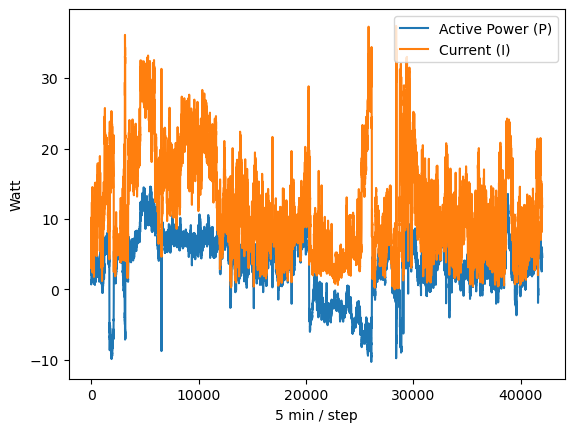

In [14]:
subset_df = df_test[df_test['TA_B1_NAME'] == 7]
field_subset_df = subset_df[subset_df["TA_B3_NAME"]==25]
P_list = field_subset_df["M_VALUE_P"].tolist()[8000:50000]
I_list = field_subset_df["M_VALUE_I"].tolist()[8000:50000]

plt.plot(P_list, label = 'Active Power (P)')
plt.plot(I_list, label = 'Current (I)')
plt.legend()
plt.ylabel('Watt')
plt.xlabel('5 min / step')
plt.show()

In [14]:
# Split train and test in to train/test X and train/test y
df_train_X = df_train[['TA_B1_NAME', 'TA_B2_NAME', 'TA_B3_NAME', 'DATUM_TIJD', 'FLAG_MEETFOUT', 'M_VALUE_I', 'BEDRIJFSSPANNING']]
df_train_y = df_train[['M_VALUE_P', "M_VALUE_Q"]]

df_test_X = df_train[['TA_B1_NAME', 'TA_B2_NAME', 'TA_B3_NAME', 'DATUM_TIJD', 'FLAG_MEETFOUT', 'M_VALUE_I', 'BEDRIJFSSPANNING']]
df_test_y = df_train[['M_VALUE_P', "M_VALUE_Q"]]

In [154]:
# Split train and test in to train/test X and train/test y with less features
# df_train_X = df_train[['DATUM_TIJD', 'FLAG_MEETFOUT', 'M_VALUE_I', 'BEDRIJFSSPANNING']]
# df_train_y = df_train[['M_VALUE_P', "M_VALUE_Q"]]

# df_test_X = df_train[['DATUM_TIJD', 'FLAG_MEETFOUT', 'M_VALUE_I', 'BEDRIJFSSPANNING']]
# df_test_y = df_train[['M_VALUE_P', "M_VALUE_Q"]]

In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor

model = LinearRegression()
model.fit(df_train_X, df_train_y)

LinearRegression()

In [156]:
predict = model.predict(df_test_X)
df_predict = pd.DataFrame(predict, columns =['M_VALUE_P', 'M_VALUE_Q'], dtype = float)

In [157]:
df_new_predict = df_predict.copy()
df_test_y = df_test_y.rename(columns={"M_VALUE_P": "M_TRUE_P", "M_VALUE_Q": "M_TRUE_Q"})
df_new_predict["M_TRUE_P"] = df_test_y["M_TRUE_P"]
df_new_predict["M_TRUE_Q"] = df_test_y["M_TRUE_Q"]

In [158]:
df_new_predict

,M_VALUE_P,M_VALUE_Q,M_TRUE_P,M_TRUE_Q
0,-2.900453,0.895569,0.00,0.00
1,0.488883,-0.038912,0.92,0.53
2,0.475009,-0.038642,0.23,0.01
3,0.461134,-0.038373,0.27,0.02
4,0.761209,-0.043030,0.22,-0.03
...,...,...,...,...
8344835,-0.751176,0.054385,0.00,0.00
8344836,-0.292897,0.010380,-3.94,1.17
8344837,-0.170817,0.026146,1.71,0.32
8344838,0.261674,0.034707,0.01,-0.23


In [159]:
df_sign = df_new_predict.copy()
for col in df_sign.columns:
    df_sign[col] = df_sign[col].apply(lambda x: -1 if x<0 else 1)

df_sign["P_PRED"] = df_sign["M_VALUE_P"] == df_sign["M_TRUE_P"]
df_sign["Q_PRED"] = df_sign["M_VALUE_Q"] == df_sign["M_TRUE_Q"]

In [160]:
print(df_sign["P_PRED"].value_counts(normalize=True))
print(df_sign["Q_PRED"].value_counts(normalize=True))


True     0.589247
False    0.410753
Name: P_PRED, dtype: float64
False    0.508468
True     0.491532
Name: Q_PRED, dtype: float64


In [ ]:
# Timepoint: average every 5 minutes
time_hrv_df = hrv_df.loc[hrv_df["DATUM_TIJD"] == "2021-01-01 00:00:00"]
time_hrv_df = time_hrv_df.sort_values(by='DATUM_TIJD', inplace=False)


time = time_hrv_df["DATUM_TIJD"].tolist()
P = time_hrv_df["M_VALUE_P"].tolist()
Q = time_hrv_df["M_VALUE_Q"].tolist()
I = time_hrv_df["M_VALUE_I"].tolist()
U = time_hrv_df["BEDRIJFSSPANNING"].tolist()

time_hrv_df

In [ ]:
P = np.array(P)
Q = np.array(Q)
I = np.array(I)
U = np.array(U)

S_ui = U*I*np.sqrt(3)
S_pq = np.sqrt(Q**2 + P**2)

print(I, sum(I))


In [ ]:
min_time = 20000
max_time = 5000+min_time
plt.plot(time[min_time:max_time], P[min_time:max_time], label = "P")
plt.plot(time[min_time:max_time], Q[min_time:max_time], label = "Q")
# plt.plot(time, I, label = "I")
plt.legend()
plt.show()

10 installaties/stations (10.5 kV installatie / onderstation) in totaal 500 installaties met grotendeels alleen I meting

TA_B1_NAME: Station
TA_B2_NAME: Installatie
TA_B3_NAME: veld

flag_meetfout

powerfactor: cos phi = P/S


I data -> P & Q inferren, of power factor

Bedrijfsspanning: in megavolt
S = MVA



Schakel events rekening mee houden? Nee

flags? mwa


dichte bol = gesloten schakelaar (in tekeningen)


Naar IT analytics